# Qiskit Aer: Pulse Simulator

To do:
- Intro to PulseSystemModel, using generators for transmon systems
- Doing a simulation follow-up to the previous point: set up a system, create some sort of basic `Schedule`, show how to run it. Not sure if this should be something that generates an interesting plot, or just something that shows how to run the simulator.
- Example of running something on a device, then running it on the simulator, where the `PulseSystemModel` has been generated from the backend
    - This needs to be a calibration procedure, preferably similar to Dave's notebook for ease

## Introduction

This notebook shows how to use the Aer pulse simulator, which simulates an OpenPulse `Schedule` on a quantum system at the Hamiltonian level.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import IBMQ

# for constructing and specifying pulse experiments
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

# system model object
from qiskit.providers.aer.openpulse.pulse_system_model import PulseSystemModel

# function for construct transmon device models
from qiskit.providers.aer.openpulse.transmon_model_generators import transmon_system_model

## Models of pulse devices

The physical model is stored in a `PulseSystemModel` object. This object stores all information required to specify a physical system ready for pulse control.

### Generating transmon models from user specified inputs

The function `transmon_system_model` constructs a `PulseSystemModel` for a transmon system specified in terms of individual qubit terms, and a coupling map with coupling strenghts.

In [ ]:
# number of qubits and cutoff dimensions
num_transmons = 2
dim_transmons = 3

# frequencies for transmon drift terms, harmonic term and anharmonic term
transmon_freqs = [5.0, 5.1]
anharmonicity_freqs = [-0.33, -0.33]

# transmon drive strengths
drive_strengths = [0.02, 0.02]

# specify coupling as a dictionary (it says qubits 0 and 1 are coupled with a coefficient 0.02)
coupling_dict = {(0,1): 0.01}

# time 
dt = 1.

# create the model
user_defined_model, cr_idx_dict = transmon_system_model(num_transmons=num_transmons, 
                                                        dim_transmons=dim_transmons,
                                                        transmon_freqs=transmon_freqs,
                                                        anharm_freqs=anharmonicity_freqs,
                                                        drive_strengths=drive_strengths,
                                                        coupling_dict=coupling_dict,
                                                        dt=dt)

The returned items are: 
- `system_model`, an instance of `PulseSystemModel` consumable by the simulator representing the specified transmon system model. 
- `cr_idx_dict`, a dict storing information on the index of the channel for a given CR drive. Specifically, when two qubits are coupled in the model, two CR drive channels are created for doing CR drives in both directions, and `cr_idx_dict` keeps track of the indices for these channels. E.g. in the above we specified the coupling `(0,1)`. When performing a CR drive on qubit 0 with target 1, use u channel with index `cr_idx_dict[(0,1)]`, and when performing a CR drive on qubit 1 with target 0, use u channel with index `cr_idx_dict[(1,0)]`

### Generating transmon models from backends

Alternatively, one may wish to model from an IBM backend. In this case, it is possible to construct one from the backend. The `ibmq_armonk` backend is a single qubit, pulse-enabled device.

In [7]:
provider = IBMQ.load_account()
provider.backends()
armonk_backend = provider.get_backend('ibmq_armonk')

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


We can construct a model directly from the backend using the `.from_backend` constructor.

In [37]:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

armonk_model.hamiltonian._variables

OrderedDict([('omegad0', 0), ('wq0', 31.254351486844612)])

Note: the above is problematic, as the numbers for the hamiltonian in the backend don't necessarily even have values, e.g. the drive strength in the armonk backend is set to $0$, presumably as there is no well known 'reasonable' number to put in. Furthermore, the units of the qubit frequency are in $rad \times$ GHz still, so are inconsistent with the Hz convention.

The easiest way around this might be to re-introduce the 'set variable' method back into `HamiltonianModel`.

# Running a pulse schedule on the simulator

First, construct a list of pulse experiments in `Schedule` objects. 

Note: This is taken directly from
https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/1a_calibrating_a_qubit.ipynb
One option is to not run it on the device here at all, but to just reference that tutorial. On the other hand, if that tutorial changes it could mess things up here.

In [21]:
defaults = armonk_backend.defaults()
config = armonk_backend.configuration()

circ_inst_map = defaults.circuit_instruction_map

measure = circ_inst_map.get('measure', qubits=config.meas_map[0])

# qubit to use for experiment
qubit = 0

# exp configuration
exps = 64
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 1.0, exps)
drive_samples = 2048
drive_sigma = 256

# scaling factor for data returned by backend
# note: You may have to adjust this for the backend you use
scale_factor=1e-10

# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(pulse.DriveChannel(qubit))
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)
    
rabi_qobj = assemble(schedules, armonk_backend, 
                     meas_level=MeasLevel.KERNELED, 
                     meas_return=MeasReturnType.AVERAGE, 
                     shots=shots)

Run the job

In [23]:
job = armonk_backend.run(rabi_qobj)

In [40]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [41]:
rabi_result = job.result(timeout=3600)

Pi Amplitude 0.328711


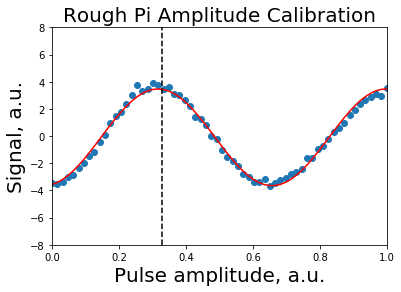

In [58]:
qubit_rabi_data = np.ones(exps, dtype=np.complex_)
for i in range(exps):
    qubit_rabi_data[i] = rabi_result.get_memory(i)[qubit]*scale_factor
    
    
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)    

rabi_amp_data = get_amplitude(qubit_rabi_data)

fit_func = lambda x,A,B,Omega,phi: (A*np.cos(2*np.pi*x/Omega+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, drive_amps, rabi_amp_data, [7.0,0.0,1.0,0.3])

#get the pi amplitude
pi_amp = (np.pi-fitparams[3])*fitparams[2]/4/np.pi
#pi_amp = (fitparams[3])*fitparams[2]/2/np.pi

plt.scatter(drive_amps, rabi_amp_data)
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.xlim(0, 1)
plt.ylim(-8, 8)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)

print('Pi Amplitude %f'%(pi_amp))

## Run it on the simulator

In [61]:
# number of qubits and cutoff dimensions
num_transmons = 1
dim_transmons = 2

# frequencies for transmon drift terms, harmonic term and anharmonic term
transmon_freqs = [5.0]
anharmonicity_freqs = [-0.33]

# transmon drive strengths
drive_strengths = [0.02]

# specify coupling as a dictionary (it says qubits 0 and 1 are coupled with a coefficient 0.02)
coupling_dict = {}

# time 
dt = 1.

# create the model
armonk_model, cr_idx_dict = transmon_system_model(num_transmons=num_transmons, 
                                                  dim_transmons=dim_transmons,
                                                  transmon_freqs=transmon_freqs,
                                                  anharm_freqs=anharmonicity_freqs,
                                                  drive_strengths=drive_strengths,
                                                  coupling_dict=coupling_dict,
                                                  dt=dt)

ValueError: not enough values to unpack (expected 2, got 0)

In [34]:
armonk_model.hamiltonian._system

[(Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
  Qobj data =
  [[0. 0.]
   [0. 2.]], 'wq0/2'),
 (Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
  Qobj data =
  [[0. 1.]
   [1. 0.]], 'omegad0*D0')]

[0]

In [66]:
from qiskit.providers.aer.openpulse.transmon_model_generators import _coupling_graph

In [67]:
test = _coupling_graph({})

In [71]:
test.sorted_graph

[]

In [72]:
len([[]])

1